# Orbit Computation

This tutorial demonstrates how to generate satellite orbits using various models.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [2]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [4]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Time = Physics.Time
Trajectory = Astrodynamics.Trajectory
Orbit = Trajectory.Orbit

---

## SGP4

### Computation

Create a Classical Orbital Element (COE) set:

In [5]:
a = Length.Kilometers(7000.0)
e = 0.0001
i = Angle.Degrees(35.0)
raan = Angle.Degrees(40.0)
aop = Angle.Degrees(45.0)
nu = Angle.Degrees(50.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

Setup a Keplerian orbital model:

In [6]:
epoch = Time.Instant.DateTime(Time.DateTime(2018, 1, 1, 0, 0, 0), Time.Scale.UTC)
earth = Physics.Environment.Objects.CelestialBodies.Earth.Analytical(epoch)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No)

Create a Two-Line Element (TLE) set:

In [7]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

Setup a SGP4 orbital model:

In [8]:
sgp4_model = Orbit.Models.SGP4(tle)

Setup the orbit:

In [9]:
# orbit = Orbit(keplerian_model)
orbit = Orbit(sgp4_model)

Now that the orbit is set, we can compute the satellite position:

In [10]:
start_instant = Time.Instant.DateTime(Time.DateTime(2018, 1, 1, 0, 0, 0), Time.Scale.UTC)
end_instant = Time.Instant.DateTime(Time.DateTime(2018, 1, 2, 0, 0, 0), Time.Scale.UTC)

In [11]:
interval = Time.Interval.Closed(start_instant, end_instant)

In [12]:
step = Time.Duration.Minutes(1.0)

Generate time grid:

In [13]:
instants = interval.generateGrid(step)

In [14]:
states = [[instant, orbit.getStateAt(instant)] for instant in instants]

In [15]:
orbit_data = [
                [
                    float(instant.getModifiedJulianDate(Time.Scale.UTC)),
                    *state.accessPosition().getCoordinates().transpose()[0].tolist(),
                    *state.accessVelocity().getCoordinates().transpose()[0].tolist()
                ]
                for [instant, state] in states
            ]

In [16]:
orbit_df = pd.DataFrame(orbit_data, columns=['$MJD^{UTC}$', '$x_{x}^{ECI}$', '$x_{y}^{ECI}$', '$x_{z}^{ECI}$', '$v_{x}^{ECI}$', '$v_{y}^{ECI}$', '$v_{z}^{ECI}$'])

In [17]:
orbit_df.head()

,$MJD^{UTC}$,$x_{x}^{ECI}$,$x_{y}^{ECI}$,$x_{z}^{ECI}$,$v_{x}^{ECI}$,$v_{y}^{ECI}$,$v_{z}^{ECI}$
0,58119.000000,5.092027e+06,-4.257870e+05,-4.466822e+06,-2299.792589,6893.814899,-3274.940077
1,58119.000694,4.940621e+06,-3.379647e+04,-4.652906e+06,-2711.599091,6900.353801,-2925.536624
2,58119.001389,4.766589e+06,3.583488e+05,-4.817620e+06,-3110.917357,6875.289966,-2562.761783
3,58119.002083,4.570730e+06,7.488533e+05,-4.960210e+06,-3495.932550,6818.748449,-2188.276951
4,58119.002778,4.353946e+06,1.135929e+06,-5.080025e+06,-3864.896226,6730.995861,-1803.794359


### Output

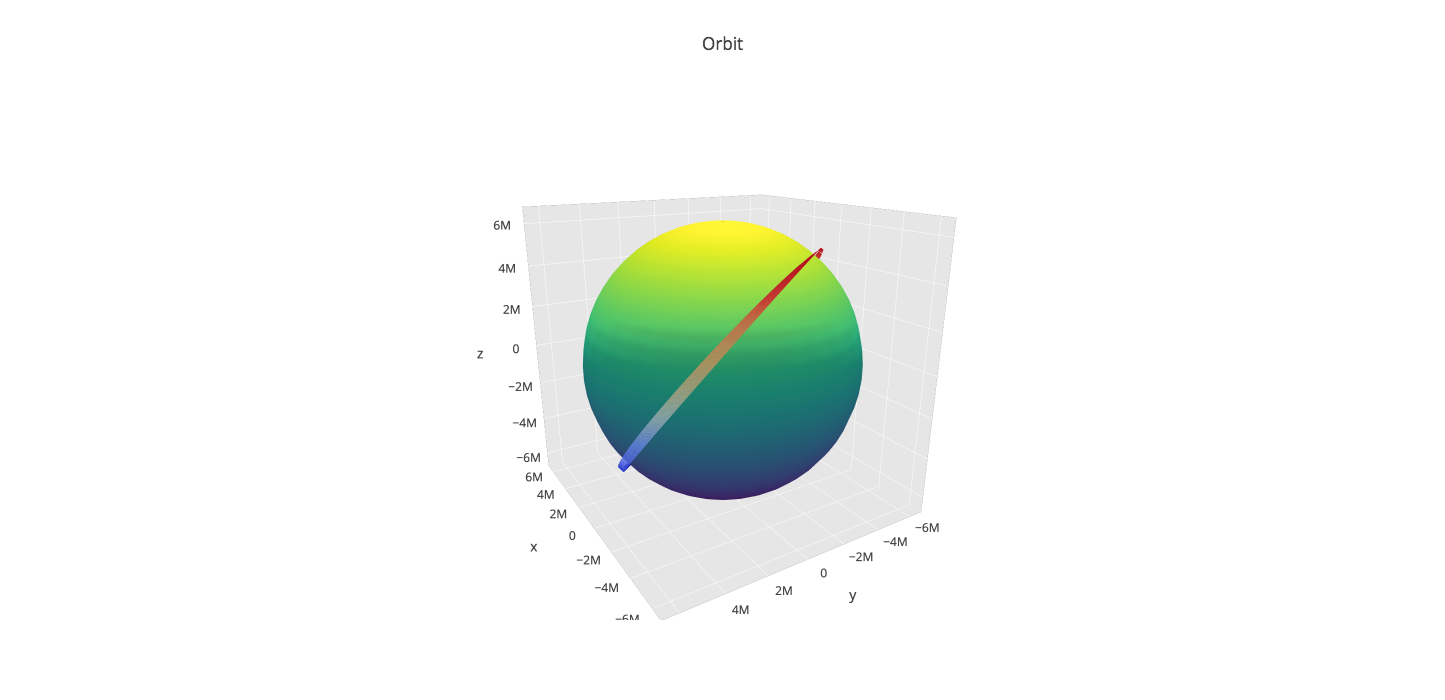

In [19]:
theta = np.linspace(0, 2 * np.pi, 30)
phi = np.linspace(0, np.pi, 30)

theta_grid, phi_grid = np.meshgrid(theta, phi)

r = float(Physics.Environment.Objects.CelestialBodies.Earth.EquatorialRadius.inMeters())

x = r * np.cos(theta_grid) * np.sin(phi_grid)
y = r * np.sin(theta_grid) * np.sin(phi_grid)
z = r * np.cos(phi_grid)

earth = go.Surface(
    x=x,
    y=y,
    z=z,
    colorscale='Viridis',
    showscale=False
)

trace = go.Scatter3d(
    x=orbit_df['$x_{x}^{ECI}$'],
    y=orbit_df['$x_{y}^{ECI}$'],
    z=orbit_df['$x_{z}^{ECI}$'],
    mode='lines',
    marker=dict(
        size=0,
        color=orbit_df['$x_{z}^{ECI}$'],
        colorscale='Viridis',
        showscale=False
    ),
    line=dict(
        color=orbit_df['$x_{z}^{ECI}$'],
        width=1,
        showscale=False
    )
)

data = [earth, trace]

layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='Orbit',
    showlegend=False,
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig)

In [ ]:
plot_data = [
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{x}^{ECI}$']
    ),
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{y}^{ECI}$']
    ),
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{z}^{ECI}$']
    )
]

In [ ]:
iplot(plot_data)